<a href="https://colab.research.google.com/github/so-radiohead/hangman/blob/master/titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First thing to mention, solving kaggle competitions differs from solving real problems in many ways, with probably the most significant one being that here you have the privilege to immediately observe your test score and thus modify your data preprocessing/algorithm/model accordingly to make new submissions. 

Which is not usualy the case in real world.

A noticable part of this code is a good example of the mentioned issue, meaning that in some places general ML logic was substitued in favor of perfecting the test score (that I had access to along the way). Of course it's not the case of me completely manipulating the code to get the desired result, and overall the initial logic flow was preserved.

It is also worth mentioning that `titanic` dataset is agreat field for data tweaking and experimenting which implies that there are lots of different approaches to extract info from data, implement feature engineering, etc. This one is obviously hugly incomplete and allows for various future manipulations (some of which are mentioned in the code).

This notebook got me a public score of `0.81339`, which is infinitely far from perfect, but still pretty decent try considering the scoring of most notebooks I've looked into.

In [331]:
#for missing values imputation
!pip install impyute
from impyute.imputation.cs import mice

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#algos
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score, classification_report

In [332]:
df = pd.read_csv('train.csv') #train set
df_test = pd.read_csv('test.csv') #test set

print(df.shape) 
print(df.head())
print(df_test.shape) 
print(df_test.head())

(891, 12)
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN    

In [333]:
#concatenate sets
concat = pd.concat([df, df_test], ignore_index=True)

print(concat.shape)
print(concat.tail())

(1309, 12)
      PassengerId  Survived  Pclass                          Name     Sex  \
1304         1305       NaN       3            Spector, Mr. Woolf    male   
1305         1306       NaN       1  Oliva y Ocana, Dona. Fermina  female   
1306         1307       NaN       3  Saether, Mr. Simon Sivertsen    male   
1307         1308       NaN       3           Ware, Mr. Frederick    male   
1308         1309       NaN       3      Peter, Master. Michael J    male   

       Age  SibSp  Parch              Ticket      Fare Cabin Embarked  
1304   NaN      0      0           A.5. 3236    8.0500   NaN        S  
1305  39.0      0      0            PC 17758  108.9000  C105        C  
1306  38.5      0      0  SOTON/O.Q. 3101262    7.2500   NaN        S  
1307   NaN      0      0              359309    8.0500   NaN        S  
1308   NaN      1      1                2668   22.3583   NaN        C  


# EDA

In [334]:
pd.set_option('display.max_columns', None)

print(concat.info())
print('_'*40)
print(concat.describe())

print('_'*40)
print('NaN values')
print('_'*40)
print(concat.isna().sum()) # all nans

print('_'*40)
print('Zero values')
print('_'*40)
print(concat[concat==0.].count()) # all zeros

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB
None
________________________________________
       PassengerId    Survived       Pclass          Age        SibSp  \
count  1309.000000  891.000000  1309.000000  1046.000000  1309.000000   
mean    655.000000    0.383838     2.294882    29

Let's explore every feature step by step. Let's start with `Cabin` as most of the missing values are in there.

In [335]:
print(concat.Cabin.unique())

[nan 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78' 'D33'
 'B30' 'C52' 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12' 'D26' 'C110'
 'B58 B60' 'E101' 'F E69' 'D47' 'B86' 'F2' 'C2' 'E33' 'B19' 'A7' 'C49'
 'F4' 'A32' 'B4' 'B80' 'A31' 'D36' 'D15' 'C93' 'C78' 'D35' 'C87' 'B77'
 'E67' 'B94' 'C125' 'C99' 'C118' 'D7' 'A19' 'B49' 'D' 'C22 C26' 'C106'
 'C65' 'E36' 'C54' 'B57 B59 B63 B66' 'C7' 'E34' 'C32' 'B18' 'C124' 'C91'
 'E40' 'T' 'C128' 'D37' 'B35' 'E50' 'C82' 'B96 B98' 'E10' 'E44' 'A34'
 'C104' 'C111' 'C92' 'E38' 'D21' 'E12' 'E63' 'A14' 'B37' 'C30' 'D20' 'B79'
 'E25' 'D46' 'B73' 'C95' 'B38' 'B39' 'B22' 'C86' 'C70' 'A16' 'C101' 'C68'
 'A10' 'E68' 'B41' 'A20' 'D19' 'D50' 'D9' 'A23' 'B50' 'A26' 'D48' 'E58'
 'C126' 'B71' 'B51 B53 B55' 'D49' 'B5' 'B20' 'F G63' 'C62 C64' 'E24' 'C90'
 'C45' 'E8' 'B101' 'D45' 'C46' 'D30' 'E121' 'D11' 'E77' 'F38' 'B3' 'D6'
 'B82 B84' 'D17' 'A36' 'B102' 'B69' 'E49' 'C47' 'D28' 'E17' 'A24' 'C50'
 'B42' 'C148' 'B45' 'B36' 'A21' 'D34' 'A9' 'C31' 'B61' 'C5

In [336]:
print(concat.Cabin.str[0].unique())

[nan 'C' 'E' 'G' 'D' 'A' 'B' 'F' 'T']


So we can extract deck (floor) value from there

In [337]:
cabins = ['A','B','C','D','E','F','G','T']

# let's find out the number of passengers on each deck, survival rate and 
#the most common Pclass for that deck

cab_df = pd.DataFrame(index=['Num_pas', 'Ratio', 'Pclass_mode'], dtype=float)

for i in cabins:
  cab_df[i]=[int(len(df[(df.Cabin.str[0] == i)])), 
             round(df.groupby([(df.Cabin.str[0] == i)])['Survived'].mean()[1],2), 
             int(df[(df.Cabin.str[0] == i)]['Pclass'].mode())]
                     
print(cab_df)

                 A      B      C      D      E      F    G    T
Num_pas      15.00  47.00  59.00  33.00  32.00  13.00  4.0  1.0
Ratio         0.47   0.74   0.59   0.76   0.75   0.62  0.5  0.0
Pclass_mode   1.00   1.00   1.00   1.00   1.00   2.00  3.0  1.0


We can use `Pclass` mode to encode our cabins (A-E, T - 1st, F - 2nd, G - 3rd). As far as I know, this isn't completely accurate representation of class/deck classification (on real Titanic it was different), but we're working with data we have. Of course there's plenty of other info that could be extracted here, like people sharing same cabins or having several cabins attached to them, but we'll just go with the first letter for now.

Coming back to null-values, it seems uncommon that 17 passengers have zero `Fare`s (ticket prices). Let's elaborate.

In [338]:
print(concat[concat['Fare']==0])

      PassengerId  Survived  Pclass                                   Name  \
179           180       0.0       3                    Leonard, Mr. Lionel   
263           264       0.0       1                  Harrison, Mr. William   
271           272       1.0       3           Tornquist, Mr. William Henry   
277           278       0.0       2            Parkes, Mr. Francis "Frank"   
302           303       0.0       3        Johnson, Mr. William Cahoone Jr   
413           414       0.0       2         Cunningham, Mr. Alfred Fleming   
466           467       0.0       2                  Campbell, Mr. William   
481           482       0.0       2       Frost, Mr. Anthony Wood "Archie"   
597           598       0.0       3                    Johnson, Mr. Alfred   
633           634       0.0       1          Parr, Mr. William Henry Marsh   
674           675       0.0       2             Watson, Mr. Ennis Hastings   
732           733       0.0       2                   Knight, Mr

There's something wrong with Southgampton embarkation point. We'll need to replace these zeros with the `Fare` modes for corresponding `Pclass`. Also, while we're here, let's look at single NaN `Fare` value.

In [339]:
print(concat[concat['Fare'].isna()])

      PassengerId  Survived  Pclass                Name   Sex   Age  SibSp  \
1043         1044       NaN       3  Storey, Mr. Thomas  male  60.5      0   

      Parch Ticket  Fare Cabin Embarked  
1043      0   3701   NaN   NaN        S  


We'll replace it with the mode for 3rd class.

Next one is `Name`. Here we can use prefixes to create `Title` feature.

In [340]:
print(concat.Name)
print('_'*40)

concat['Title'] = concat.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

print(concat.Title.unique()) # unique titles
print('_'*40)
print(concat.Title.value_counts()) # number of unique titles

0                                 Braund, Mr. Owen Harris
1       Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                  Heikkinen, Miss. Laina
3            Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                                Allen, Mr. William Henry
                              ...                        
1304                                   Spector, Mr. Woolf
1305                         Oliva y Ocana, Dona. Fermina
1306                         Saether, Mr. Simon Sivertsen
1307                                  Ware, Mr. Frederick
1308                             Peter, Master. Michael J
Name: Name, Length: 1309, dtype: object
________________________________________
['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer' 'Dona']
________________________________________
Mr          757
Miss        260
Mrs         197
Master       61
Dr            8
Rev           8
Col           4


First 4 categories seem prevalent, so we'll merge them with the rest judging on the sex of the title (could've also dropped everything beyond `Master`, replacing with 'rare' or something, but preserving at least some info sounds good).



We'll also use `Parch` and `SibSp` features to create two new features reflecting the size of passengers relatives, and impute missing values in `Age` and `Embarked`. So let's create our final transformation function.


# Feature engineering

In [341]:
def transform_df(df):

  # merging titles towards top-4
  df.loc[(df['Title'] == 'Dr') & (df['Sex'] == 'female'), ['Title']] = 'Mrs'
  df['Title'] = df['Title'].replace(['Capt', 'Col', 'Major', 'Rev', 'Don', 'Jonkheer','Sir', 'Dr'], 'Mr')
  df['Title'] = df['Title'].replace(['Mlle'], 'Miss')
  df['Title'] = df['Title'].replace(['Mme',  'Ms', 'Dona',  'Lady',  'Countess'], 'Mrs')

  title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4}

  df['Title'] = df['Title'].map(title_mapping)
  
  # converting sex variables
  df.loc[df.Sex == 'female', 'Sex'] = 0
  df.loc[df.Sex == 'male', 'Sex'] = 1

  # filling fare zeros as we discussed
  df.loc[(df['Fare']==0)&(df['Pclass']==1), ['Fare']] = int(df[df['Pclass']==1]['Fare'].mode())
  df.loc[(df['Fare']==0)&(df['Pclass']==2), ['Fare']] = int(df[df['Pclass']==2]['Fare'].mode())
  df.loc[(df['Fare']==0)&(df['Pclass']==3), ['Fare']] = int(df[df['Pclass']==3]['Fare'].mode())

  # filling single na value
  df.loc[df['Fare'].isna(), ['Fare']] = int(df[df['Pclass']==3]['Fare'].mode())
  
  # mapping cabins as we decided based on class. Leaving NaNs for now
  df.loc[df.Cabin.str[0] == 'A', 'Cabin'] = 1
  df.loc[df.Cabin.str[0] == 'B', 'Cabin'] = 1
  df.loc[df.Cabin.str[0] == 'C', 'Cabin'] = 1
  df.loc[df.Cabin.str[0] == 'D', 'Cabin'] = 1
  df.loc[df.Cabin.str[0] == 'E', 'Cabin'] = 1
  df.loc[df.Cabin.str[0] == 'F', 'Cabin'] = 2
  df.loc[df.Cabin.str[0] == 'G', 'Cabin'] = 3
  df.loc[df.Cabin.str[0] == 'T', 'Cabin'] = 1
  
  # filling 3 missing embarked values with 'S', which is the most common one 
  # (and also correct, judging on real Titanic info)
  df.Embarked.fillna('S', inplace=True)
  df.loc[df.Embarked == 'C', 'Embarked'] = 1
  df.loc[df.Embarked == 'Q', 'Embarked'] = 2
  df.loc[df.Embarked == 'S', 'Embarked'] = 3
  
  # using SibSp and Parch for feature engineering
  df['FamilySize'] = df['SibSp'] + df['Parch'] + 1 # count overall size of family
  df['IsAlone'] = 0
  df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1 # introduce new feature reflecting 
  # whether passenger was travelling by their own or had at least 1 relative

  # dropping redundant columns here to make df available for converting to float
  # for the next step. At this step ypu can try to include ticket values and 
  # group passengers using heir family names from Name, but we'll skip that
  df.drop(['Ticket', 'Name', 'PassengerId', 'Survived'], inplace=True, axis=1)
  df = df.astype(float)

  # age imputation using mice seems to work a little bit better than using
  # modes/medians, preserving more of an original data distribution
  imputed = mice(df.values)
  ages = imputed[:, 2]
  ages = [0 if age < 0 else age for age in ages] # choose only positive ages
  df['Age'] = ages

  return df.astype(float)

You've noticed that we haven't conducted any categorical encoding and splitting continious variables into bins. In that notebook we'll use just two tree-based classification algorithms, which are pretty indifferent to categorical encodings, scalers and PCA/t-SNE (all of which come handy in case of regression but don't improve performance of `Random Forest` and `XGBClassifier`), so that will not be included.

We also haven't dropped any close-like features (say, `FamilySize` and `IsAlone`). We'll do this as a final step after finishing missing values imputation and correlation analysis.

We will apply defined function to concatenated dataset to preserve integrity of its possible statistical relations, and then we'll again divide it into train and test set.



In [342]:
X_concat = transform_df(concat)

print(X_concat.shape)
print(X_concat.isna().sum())

(1309, 11)
Pclass           0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Cabin         1014
Embarked         0
Title            0
FamilySize       0
IsAlone          0
dtype: int64


Now let's deal with those 1014 `Cabin` missing values.

In [343]:
print(X_concat.corr(method='spearman')['Cabin'])

Pclass        0.805946
Sex          -0.018976
Age          -0.320165
SibSp        -0.025032
Parch         0.121227
Fare         -0.423823
Cabin         1.000000
Embarked      0.174737
Title         0.072396
FamilySize    0.049668
IsAlone       0.029675
Name: Cabin, dtype: float64


Seems like we can try to recreate `Cabin` from `Pclass`, `Age` and `Fare` values. Note that hereinafter we use Spearman method to calculate correlaiton.

In [344]:
imput_cab = X_concat.loc[:, ['Fare', 'Age', 'Pclass', 'Cabin']]

# preparing data for classifier
imput_cab_test = imput_cab[imput_cab['Cabin'].isna()] # choose rows with NaN Cabin
cab_Xtest = imput_cab_test.drop(columns='Cabin').to_numpy()

imput_cab_train = imput_cab.dropna()
cab_Xtrain = imput_cab_train.drop(columns='Cabin').to_numpy()

cab_y = imput_cab_train['Cabin'].to_numpy()

In [345]:
X_train, X_test, y_train, y_test = train_test_split(cab_Xtrain, cab_y, test_size=0.2, random_state=0)

clf = RandomForestClassifier(n_estimators=700, max_features=2, max_depth=4, min_samples_leaf=2, random_state=0) # arbitrary hyperparameters
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

1.0


We got good result because most of the cabins are ones (belonging to 1st class). Now let's impute values we got.

In [346]:
missing_cab = clf.predict(cab_Xtest)
print(f'Predicted values: {len(missing_cab)}')
print('Missing values')
print(imput_cab.isna().sum())

Predicted values: 1014
Missing values
Fare         0
Age          0
Pclass       0
Cabin     1014
dtype: int64


In [347]:
indicies_of_missing = imput_cab[imput_cab['Cabin'].isna()].index

# filling missing values
for fill_index, df_index in enumerate(indicies_of_missing):
    imput_cab.loc[df_index, 'Cabin'] = missing_cab[fill_index]


print(imput_cab)

          Fare        Age  Pclass  Cabin
0       7.2500  22.000000     3.0    2.0
1      71.2833  38.000000     1.0    1.0
2       7.9250  26.000000     3.0    2.0
3      53.1000  35.000000     1.0    1.0
4       8.0500  35.000000     3.0    1.0
...        ...        ...     ...    ...
1304    8.0500  27.739195     3.0    2.0
1305  108.9000  39.000000     1.0    1.0
1306    7.2500  38.500000     3.0    2.0
1307    8.0500  27.739195     3.0    2.0
1308   22.3583  14.828005     3.0    2.0

[1309 rows x 4 columns]


In [348]:
print(X_concat[X_concat.index.isin(imput_cab.index)])
X_concat['Cabin'].update(imput_cab['Cabin']) # updating initial df with df of imputed values

print(X_concat) # df after imputation
print(X_concat.isna().sum())

      Pclass  Sex        Age  SibSp  Parch      Fare  Cabin  Embarked  Title  \
0        3.0  1.0  22.000000    1.0    0.0    7.2500    NaN       3.0    1.0   
1        1.0  0.0  38.000000    1.0    0.0   71.2833    1.0       1.0    3.0   
2        3.0  0.0  26.000000    0.0    0.0    7.9250    NaN       3.0    2.0   
3        1.0  0.0  35.000000    1.0    0.0   53.1000    1.0       3.0    3.0   
4        3.0  1.0  35.000000    0.0    0.0    8.0500    NaN       3.0    1.0   
...      ...  ...        ...    ...    ...       ...    ...       ...    ...   
1304     3.0  1.0  27.739195    0.0    0.0    8.0500    NaN       3.0    1.0   
1305     1.0  0.0  39.000000    0.0    0.0  108.9000    1.0       1.0    3.0   
1306     3.0  1.0  38.500000    0.0    0.0    7.2500    NaN       3.0    1.0   
1307     3.0  1.0  27.739195    0.0    0.0    8.0500    NaN       3.0    1.0   
1308     3.0  1.0  14.828005    1.0    1.0   22.3583    NaN       1.0    4.0   

      FamilySize  IsAlone  
0          

# Feature selection

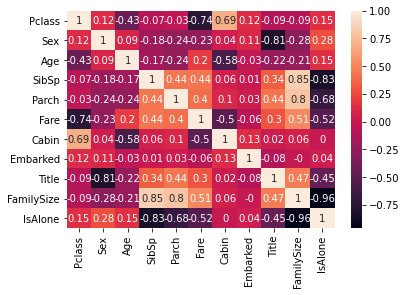

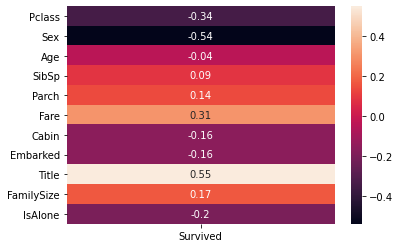

In [349]:
X = X_concat

sns.heatmap(X.corr(method='spearman').round(2), annot=True) # correlation between features
plt.show()

Xtrain = X.loc[:890,:]

corelated = pd.DataFrame({
    'Survived': [round(Xtrain[i].corr(df['Survived'], method='spearman'), 2) for i in Xtrain]
}, index=[i for i in Xtrain])

sns.heatmap(corelated, annot=True) # correlation between features and survived (for train set)
plt.show()


We'll eliminate `Age`, `SibSp`, `Parch` as the ones that have the lowest correlation with the result of survival. It is natural to exclude `SibSp` and `Parch `since we already have `FamilySize` and `IsAlone`, but eliminating `Age` seems to be a little counterintuitive - as well as leaving both `FamilySize` and `IsAlone`. Although it seems to lead to the best result when scalers are not used.

In [350]:
X.drop(columns=['Age', 'SibSp', 'Parch'], inplace=True)

It's useful to understand how our feature engineering/selection influenced our data. In particular, we can spot which samples will create confusion for our ML model because being encoded in the same way (so model can't distinguish them) but having different labels. So let's see what passengers have different survival results but the same feature representation after data preprocessing.

In [351]:
# passengers that didn't survive
Xtrain_nsur = Xtrain[df['Survived']==0]
Xtrain_nsur['Id'] = Xtrain_nsur.index+1
Xtrain_nsur.reset_index(drop=True,inplace=True)

# passengers that survived
Xtrain_sur = Xtrain[df['Survived']==1]
Xtrain_sur['Id'] = Xtrain_sur.index+1
Xtrain_sur.reset_index(drop=True,inplace=True)

# intersection from both classes - meaning model will see these passengers 
# identically while they actually had different outcomes (belong to different classes)
intersected_df = pd.merge(Xtrain_nsur, Xtrain_sur, how='inner', 
on=['Pclass', 'Sex','Fare', 'Cabin','Embarked','Title','FamilySize','IsAlone'])
intersected_df.drop_duplicates(subset=['Id_x'], keep='first', inplace=True)
intersected_df.drop_duplicates(subset=['Id_y'], keep='first', inplace=True)

pd.set_option('display.max_columns', None)


comp = intersected_df.rename(columns={'Id_x':'Not_survived',
                                     'Id_y':'Survived'})
print(comp)

# for future analysis
comp.to_excel('intersection.xlsx', index=False)
df.to_excel('initial_df.xlsx', index=False)

# now let's print intersections from initial df
dataframes = []
i=0
for i in comp.index.to_numpy():
  data = []
  data.append(list(df.loc[comp.loc[i,:]['Not_survived']-1,:]))
  data.append(list(df.loc[comp.loc[i,:]['Survived']-1,:]))
  print(pd.DataFrame(data, columns=df.columns))
  print(' '*40)
  print('_'*40)
  dataframes.append(pd.DataFrame(data))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


     Pclass  Sex      Age_x  SibSp_x  Parch_x      Fare  Cabin  Embarked  \
0       3.0  1.0  35.000000      0.0      0.0    8.0500    1.0       3.0   
20      3.0  1.0  20.000000      0.0      0.0    8.0500    2.0       3.0   
98      3.0  0.0  14.000000      0.0      0.0    7.8542    2.0       3.0   
100     3.0  1.0  26.807323      0.0      0.0    7.2250    2.0       1.0   
109     2.0  1.0  66.000000      0.0      0.0   10.5000    1.0       3.0   
115     1.0  1.0  42.000000      1.0      0.0   52.0000    1.0       3.0   
117     3.0  1.0  26.806770      0.0      0.0    7.8958    2.0       1.0   
121     3.0  1.0  28.500000      0.0      0.0    7.2292    2.0       1.0   
139     3.0  1.0  20.000000      0.0      0.0    7.8542    2.0       3.0   
145     2.0  1.0  34.000000      1.0      0.0   26.0000    2.0       3.0   
148     3.0  1.0  21.000000      0.0      0.0    7.9250    2.0       3.0   
151     3.0  1.0  70.500000      0.0      0.0    7.7500    2.0       2.0   
179     3.0 

Most of the intersections are either differing on age (which is still not an important feature judging on correlation heatmap) or there is space for variation because of the multiple NaNs. We can also see that some deaths/survivings seem to be completely random and driven by chance and not by some sort of rule or regularity we hope to derive using ML techniques. Say, there are plenty of random unfortunate events that could impede passengers id201 or id200 from survival while letting passengers id82 and id346 survive. Recreating such circumstances in form of data engineering will take a lot of fantasy and time.

In [352]:
# splitting datasets again and preparing data for ML models
Xtrain = X.loc[:890,:]
Xtest = X.loc[891:,:]

# universal recipe for surviving/dying on Titanic
print(Xtrain[df['Survived']==0].mode(axis=0)) # most common deadly values
print(Xtrain[df['Survived']==1].mode(axis=0)) # most common survival values

Xtrain = Xtrain.to_numpy()
Xtest = Xtest.to_numpy()

train_labels_df = df['Survived']
train_labels = train_labels_df.to_numpy()
y = train_labels.flatten()

print(Xtrain.shape)
print(Xtest.shape)

   Pclass  Sex  Fare  Cabin  Embarked  Title  FamilySize  IsAlone
0     3.0  1.0  8.05    2.0       3.0    1.0         1.0      1.0
   Pclass  Sex  Fare  Cabin  Embarked  Title  FamilySize  IsAlone
0     1.0  0.0  13.0    1.0       3.0    2.0         1.0      0.0
(891, 8)
(418, 8)


It can be seen that in order to survive you have to be woman, occupying first class cabin and have 1 relative (probably sibling, because of `Title`=2, which corresponds to 'Miss'). Of course these values can be (and most likely are) highly biased due to missing values imputing manner (shiffting towards most common patterns using modes). You can explore more features that are vital for survival during previous steps, before some columns have been dropped.

# Prediction

In [355]:
from sklearn.model_selection import cross_validate

# cross-validate with manually chosen hyperparameters 
# some of them increase performance, others prevent overfitting
clf4 = XGBClassifier(n_estimators=700, max_features=3, max_depth=3, min_samples_leaf=2, 
                     min_child_weight=10, subsample=0.4, colsample_bytree=0.4, 
                     min_samples_split=100, learning_rate=0.02, random_state=0) 

rfe_results = cross_validate(clf4, Xtrain, y, cv  = 10, return_train_score=True)

print('Train XGB: ', rfe_results['train_score'].mean()*100)
print('Valid XGB: ', rfe_results['test_score'].mean()*100)

clf4.fit(Xtrain, y)
pred = clf4.predict(Xtest)

# make submission
submissionXGB = pd.DataFrame({'PassengerId': df_test['PassengerId'],
                           'Survived': pred})
submissionXGB.to_csv('sumbissionXGB.csv', index=False)

Train XGB:  83.33960666374016
Valid XGB:  82.04619225967541


Final notes. As I've mentioned at the beginning this version of the notebook is essentialy an attempt to coordinate problem solving with respect to pre-known desired result. Because of that a lot of methods I've implemented along the way of tryng to crack titanic are not used in this version. Some of these methods are:


1.   Obviously, using wide range of ML algorithms, including:

> `Decision Tree`

> `Random Forest Regresor` & `XGBRegressor`

> `Logistic Regression`

> `Support Vector Machines Classifier`

> `Linear Discriminant Analysis`

> `Gaussian Naive Bayes`

> Clustering passengers with `KNN`

> `SGDClassifier`

> `Gradient Boosting Classifier`

> Vanilla `Neural Network` with 3 linear layers

These methods ended up giving 75-79% accuracy on public score.


2.   `GridSearchCV` for hyperparameter tuning and feature selection using in-built sklearn methods. The problem here is that `titanic` dataset is highly prone to overfitting and since train/validation score&their ratio meant very little when it came to the public score. It was logical that 83/82 on cross-validation gave better result on public test than 93/84, but why 83/81 was better than 83/82? In general, trying out different train-valid techniques (including 3-fold, 5-fold, 10-fold cross-validation, manually written cross-validation on randomly shuffled subsets etc) hasn't revealed valid connection between training/validation scores and eventual pblic test score on kaggle. So it was kind of acting blindly.


3. Applying sklearn's scalers (`QuantileTransformer`, `PowerTransformer`, `RobustScaler`, `Normalizer`, `MaxAbsScaler`, `MinMaxScaler`, `StandardScaler`) to normalize/standartize the data before fitting the algorithm onto it, before implementing Principal Component Analysis (including merging highly correlated features into one or two components using PCA) or just in order to observe correlations.

4. Impute missing values through sklearn's imputers (`IterativeImputer`, `KNNImputer`). Also I spent a good amount of tome experimenting with defferent imputation methods - modes, medians, means  (both for values across the set or for specific feature only - like when we've imputed `Fare` values with modes of their corresponding `Pclass`es), and also external `mice` library. Creating intermediate ML algorithm and combining it all showed to be a slightly better practice.

5. Splitting continious features (`Fare`, `Age`) into 4-5 bins to do categorical encoding. Since I ended up using tree-based model, it didn't really pay off.

6. My apologies for spelling/sematic mistakes or typos.



